<a href="https://colab.research.google.com/github/OleksandraLysetska/BrooklynBridgePaper/blob/main/SARIMA_Kuch_Lys_Fun_Brooklyn_Bridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install statsmodels

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from scipy import stats

from sklearn.metrics import mean_squared_error


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/BrProject/bikecount-month2025.csv'
df = pd.read_csv(file_path)
print(df.head())

                                  Name   Count  Year  Month
0  Manhattan Bridge Bike Comprehensive   41501  2013     12
1  Manhattan Bridge Bike Comprehensive   32873  2014      1
2  Manhattan Bridge Bike Comprehensive   24676  2014      2
3  Manhattan Bridge Bike Comprehensive   56659  2014      3
4  Manhattan Bridge Bike Comprehensive  108965  2014      4


In [6]:
df[(df['Name']=='Manhattan Bridge Bike Comprehensive')][(df['Year']==2024)].describe()

/tmp/ipython-input-427664600.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[(df['Name']=='Manhattan Bridge Bike Comprehensive')][(df['Year']==2024)].describe()


,Count,Year,Month
count,12.000000,12.0,12.000000
mean,138750.250000,2024.0,6.500000
std,44035.545488,0.0,3.605551
min,72289.000000,2024.0,1.000000
25%,102929.750000,2024.0,3.750000
50%,148828.500000,2024.0,6.500000
75%,175193.250000,2024.0,9.250000
max,186068.000000,2024.0,12.000000


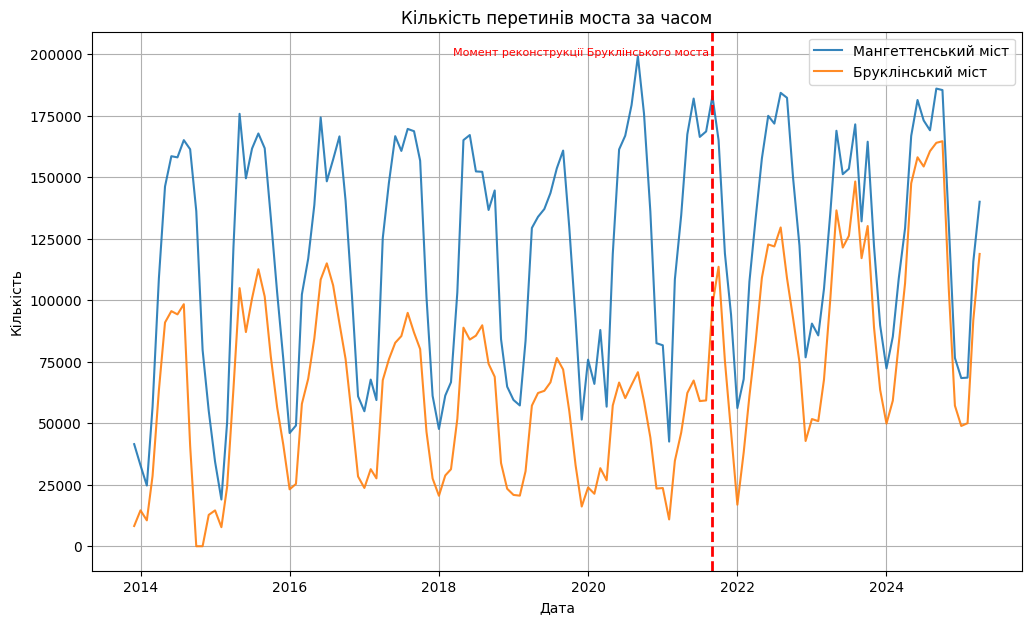

In [7]:
def plot_count_over_time_by_name(df, names):
    """
    Перетворює колонки 'Month' і 'Year' у формат datetime, фільтрує дані за колонкою 'Name'
    і будує графіки 'Count' за часом для кожного унікального значення в 'Name' на одному графіку.
    Додає позначку реконструкції Бруклінського моста (вересень 2021).
    """
    # Перетворення колонок Month і Year в datetime
    df['Date'] = pd.to_datetime(
        df['Year'].astype(str) + '-' + df['Month'].astype(str),
        format='%Y-%m'
    )

    # Сортування DataFrame за датою
    df = df.sort_values(by='Date')

    # Мапа назв для легенди
    name_map = {
        "Manhattan Bridge Bike Comprehensive": "Мангеттенський міст",
        "Comprehensive Brooklyn Bridge Counter": "Бруклінський міст"
    }

    # Побудова графіка
    plt.figure(figsize=(12, 7))
    for name in names:
        subset_df = df[df['Name'] == name]
        plt.plot(subset_df['Date'], subset_df['Count'],
                 label=name_map.get(name, name), alpha=0.9)

    # Додати вертикальну лінію для вересня 2021
    reconstruction_date = pd.to_datetime("2021-09", format="%Y-%m")
    plt.axvline(reconstruction_date, color="red", linestyle="--", linewidth=2)
    plt.text(reconstruction_date, plt.ylim()[1]*0.95,
             "Момент реконструкції Бруклінського моста ",
             rotation=0, color="red", ha="right", va="bottom", fontsize=8)

    plt.xlabel('Дата')
    plt.ylabel('Кількість')
    plt.title('Кількість перетинів моста за часом')
    plt.legend()
    plt.grid(True)
    plt.show()


# Виклик з потрібними назвами
plot_count_over_time_by_name(
    df,
    names=["Manhattan Bridge Bike Comprehensive", "Comprehensive Brooklyn Bridge Counter"]
)


/tmp/ipython-input-1717627408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth'] = filtered_data['Year'].astype(str) + '-' + filtered_data['Month'].astype(str)


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (13).

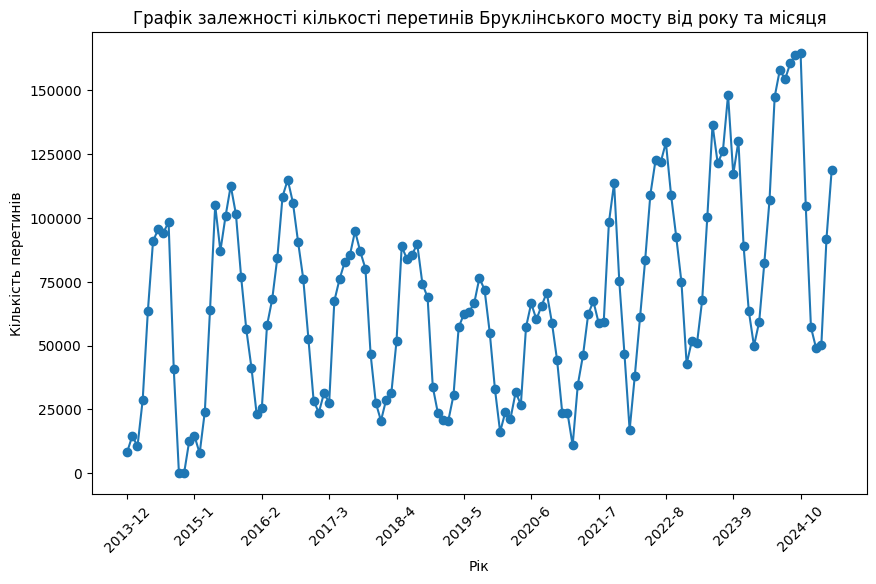

In [8]:
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)

selected_bridge = "Comprehensive Brooklyn Bridge Counter"
filtered_data = df[df['Name'] == selected_bridge]
filtered_data1 = df[(df['Name'] == selected_bridge) & (df['Year']>=2020)]

filtered_data['YearMonth'] = filtered_data['Year'].astype(str) + '-' + filtered_data['Month'].astype(str)
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['YearMonth'], filtered_data['Count'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Рік')
plt.ylabel('Кількість перетинів')
plt.title('Графік залежності кількості перетинів Бруклінського мосту від року та місяця')

num_years = len(filtered_data['Year'].unique())
plt.xticks(range(0, len(filtered_data), num_years), filtered_data['Year'].unique(), rotation=45)

plt.grid(True)
plt.show()

In [9]:
# Є сезонність, треба перетворити у стаціонарний шляхом диференціювання
# --- Стаціонарність: перетворення ---

series = filtered_data['Count'].dropna()
max_diff = 5 # максимум 5 диференціювань

for d in range(max_diff + 1):
    if d > 0:
        series_diff = series.diff(d).dropna()
    else:
        series_diff = series
    result = adfuller(series_diff)
    p_value = result[1]
    print(f'd = {d}, p-value = {p_value}')
    if p_value < 0.05:
        print(f'Стаціонарність досягнута при d = {d}')
        break
else:
    print('Ряд не стає стаціонарним до 5-го диференціювання')

d = 0, p-value = 0.9825497182839312
d = 1, p-value = 7.754404615996048e-18
Стаціонарність досягнута при d = 1


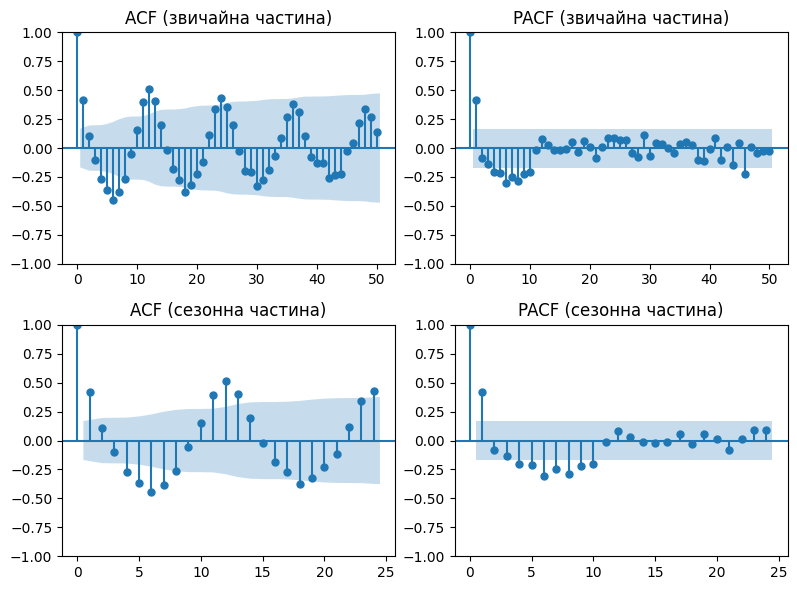

In [13]:
# Побудова ACF та PACF графіків
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# ACF та PACF для звичайної частини
plot_acf(series_diff, ax=axes[0, 0], lags=50)
axes[0, 0].set_title('ACF (звичайна частина)')
plot_pacf(series_diff, ax=axes[0, 1], lags=50, method='ywm')
axes[0, 1].set_title('PACF (звичайна частина)')

# ACF та PACF для сезонної частини — лаги кратні сезонност!
seasonal_lag = 12  # річна сезонність
plot_acf(series_diff, ax=axes[1, 0], lags=seasonal_lag*2)
axes[1, 0].set_title('ACF (сезонна частина)')
plot_pacf(series_diff, ax=axes[1, 1], lags=seasonal_lag*2, method='ywm')
axes[1, 1].set_title('PACF (сезонна частина)')

plt.tight_layout()
plt.show()

In [14]:
p = 1  # значущі піки звич ак
q = 2  # значущі піки звич чак
d = 1
P = 1  # значущі піки на лагах кратних сезонності ак
Q = 1  # значущі піки на лагах кратних сезонності чак
D = 1

In [12]:
# Обчислення автокореляції
autocorr = filtered_data['Count'].autocorr()
print(f'Autocorrelation for Brooklyn Bridge: {autocorr}')

Autocorrelation for Brooklyn Bridge: 0.8572109695042358


<Axes: title={'center': 'Виділений тренд'}>

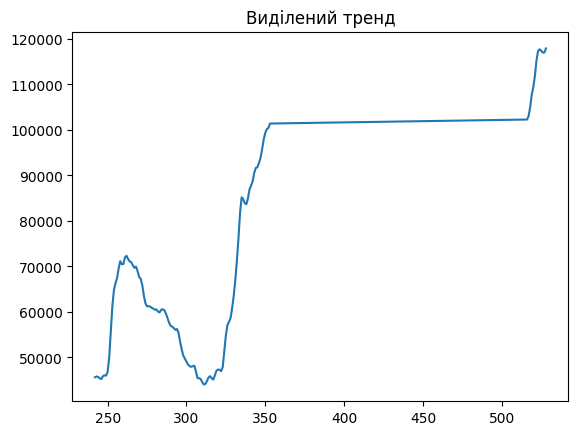

In [16]:
# @title
#перевірка чи є ще тренд
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(filtered_data['Count'], model='additive', period=12)
decomposition.trend.plot(title="Виділений тренд")

<Figure size 1000x600 with 0 Axes>

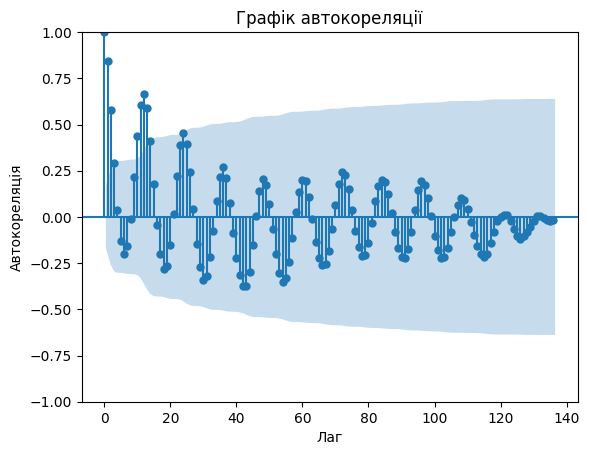

In [17]:
# Графік автокореляції

plt.figure(figsize=(10, 6))
plot_acf(filtered_data['Count'], lags=len(filtered_data) - 1)
plt.xlabel('Лаг')
plt.ylabel('Автокореляція')
plt.title('Графік автокореляції')
plt.show()  # значущі піки 1 або 2

Text(0.5, 1.0, 'Графік часткової автокореляції')

<Figure size 1000x600 with 0 Axes>

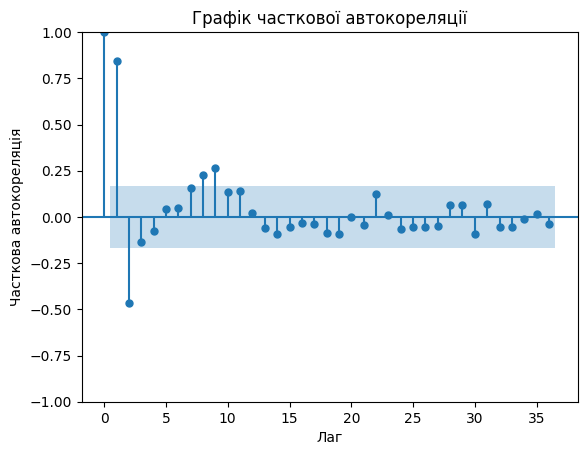

In [18]:
# Графік часткової автокореляції

plt.figure(figsize=(10, 6))
plot_pacf(filtered_data['Count'], lags=36)
plt.xlabel('Лаг')
plt.ylabel('Часткова автокореляція')
plt.title('Графік часткової автокореляції')
# значущі піки 3

/tmp/ipython-input-200901439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])


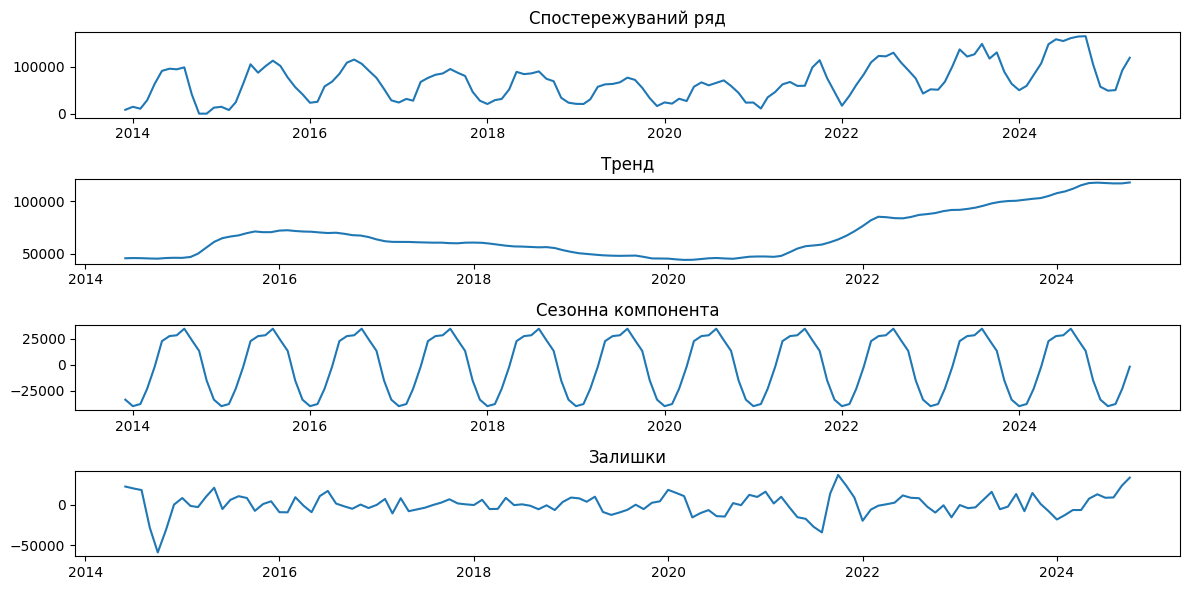

In [19]:
# Сезонна декомпозиція графік 1
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

decomposition = seasonal_decompose(filtered_data['Count'], model='additive')

plt.figure(figsize=(12, 6))

plt.subplot(411)
plt.plot(filtered_data['Count'])
plt.title('Спостережуваний ряд')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Тренд')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Сезонна компонента')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Залишки')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2325401201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
/tmp/ipython-input-2325401201.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-2325401201.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-2325401201.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an undersc

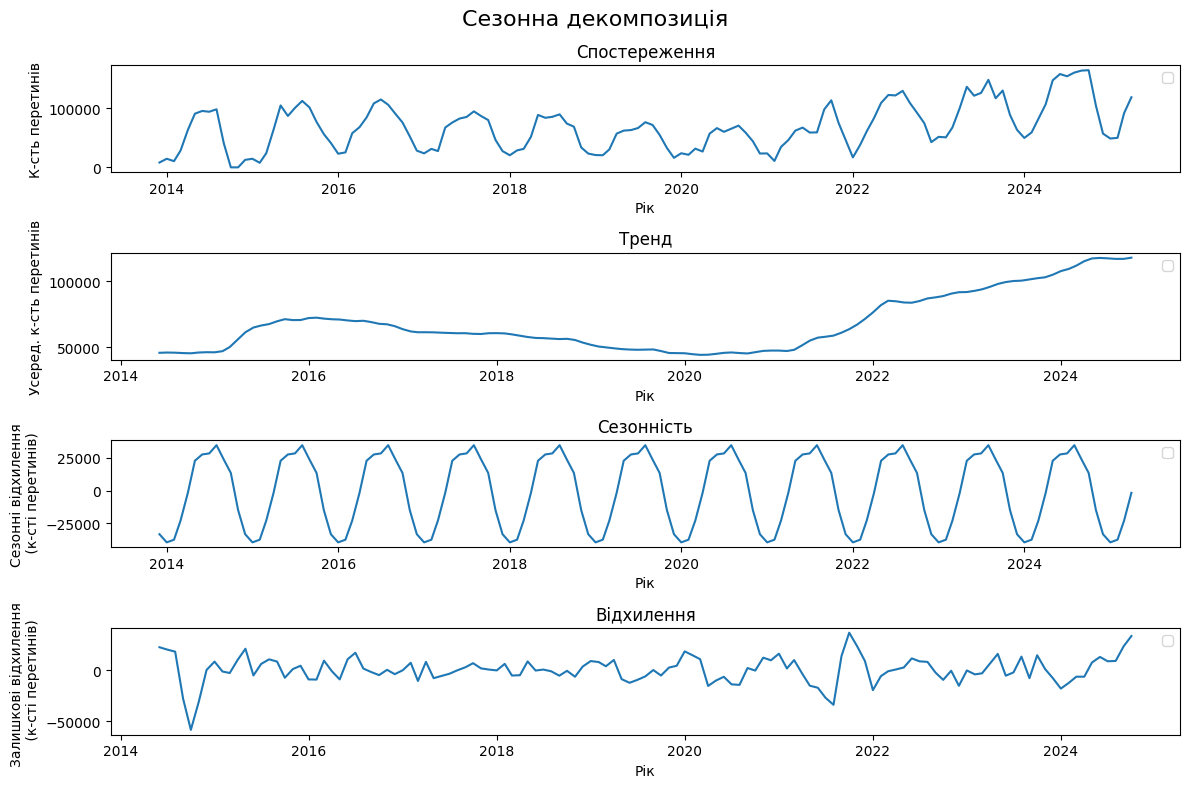

In [ ]:
# сезонна декомпозиція графік 2 (інші підписи)
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

decomposition = seasonal_decompose(filtered_data['Count'], model='additive')
plt.figure(figsize=(12, 8))
plt.suptitle('Сезонна декомпозиція', fontsize=16)

plt.subplot(411)
plt.plot(filtered_data['Count'])
plt.ylabel('К-сть перетинів')
plt.xlabel('Рік')
plt.title('Спостереження')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend)
plt.ylabel('Усеред. к-сть перетинів')
plt.xlabel('Рік')
plt.title('Тренд')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.ylabel('Сезонні відхилення\n (к-сті перетинів)')
plt.xlabel('Рік')
plt.title('Сезонність')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid)
plt.ylabel('Залишкові відхилення \n (к-сті перетинів)')
plt.xlabel('Рік')
plt.title('Відхилення')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipython-input-1734787014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments wi

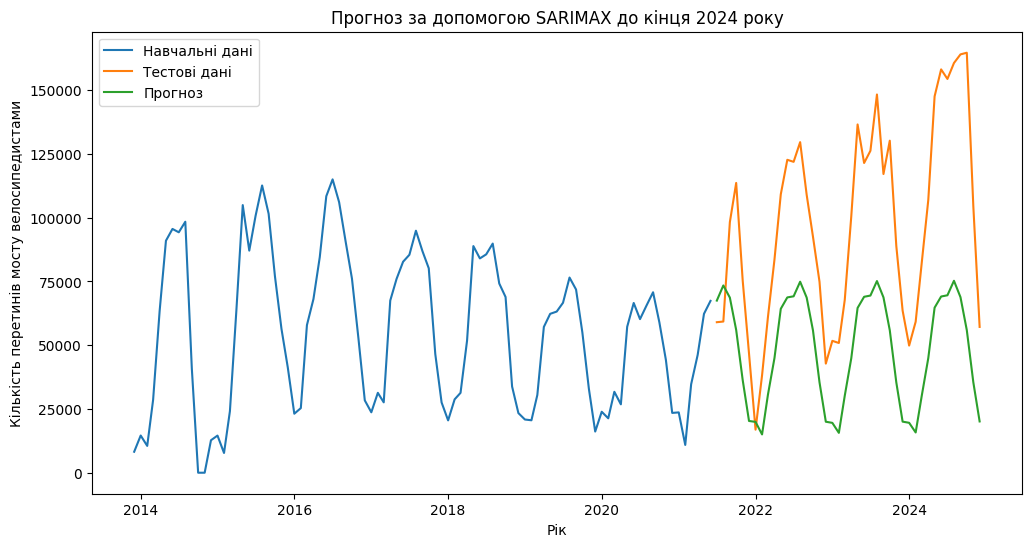

RMSE: 54984.49660755422
MAPE 0.5109215250209675


In [20]:
# Побудова SARIMA моделі
# Перевірка формату дат
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

# Навчальна вибірка до червня 2021 року
train_data = filtered_data.loc[:'2021-06']
# Тестова вибірка до 2024 року
test_data = filtered_data.loc['2021-07':'2024-12']


model = SARIMAX(train_data['Count'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

# Прогноз
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start, end, dynamic=False, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(train_data['Count'], label='Навчальні дані')
plt.plot(test_data['Count'], label='Тестові дані')
plt.plot(predictions, label='Прогноз')
plt.legend()
plt.title('Прогноз за допомогою SARIMAX до кінця 2024 року')
plt.xlabel('Рік')
plt.ylabel('Кількість перетинів мосту велосипедистами')
plt.show()

# Оцінка точності
error = rmse(test_data['Count'], predictions)
print(f'RMSE: {error}')


from sklearn.metrics import mean_absolute_percentage_error
print('MAPE', mean_absolute_percentage_error(test_data['Count'], predictions))


In [25]:
print(f'AIC: {results.aic}, BIC: {results.bic}')

AIC: 864.493404160662, BIC: 879.2316795981994


In [24]:
# === ПОРІВНЯННЯ АЛЬТЕРНАТИВНИХ SARIMA ===
import itertools

p = d = q = P = D = Q = range(1, 3)
param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q))

best_aic = float('inf')
best_order = None
best_seasonal_order = None
results_dict = []

for order in param_combinations:
    for seasonal_order in seasonal_combinations:
        try:
            model = SARIMAX(
                train_data['Count'],
                order=order,
                seasonal_order=(*seasonal_order, 12),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            results_dict.append((order, seasonal_order, results.aic, results.bic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f"Найкраща модель за AIC: {best_order} x {best_seasonal_order}12 з AIC = {best_aic}")
print("Топ-5 моделей за AIC:")
sorted_results = sorted(results_dict, key=lambda x: x[2])[:5]
for res in sorted_results:
    print(f"Order={res[0]}, Seasonal={res[1]}, AIC={res[2]:.2f}, BIC={res[3]:.2f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Li

Найкраща модель за AIC: (1, 2, 1) x (1, 1, 2)12 з AIC = 188.14398361508404
Топ-5 моделей за AIC:
Order=(1, 2, 1), Seasonal=(1, 1, 2), AIC=188.14, BIC=199.73
Order=(2, 2, 2), Seasonal=(1, 2, 2), AIC=863.33, BIC=876.43
Order=(1, 2, 2), Seasonal=(1, 2, 2), AIC=863.72, BIC=875.19
Order=(2, 2, 2), Seasonal=(2, 2, 2), AIC=864.49, BIC=879.23
Order=(1, 2, 2), Seasonal=(2, 2, 2), AIC=865.31, BIC=878.41


In [ ]:
# Перевірка на нормальний розподіл
stat, p1 = stats.shapiro(test_data['Count'])
stat, p2 = stats.shapiro(predictions)

# Виконання тесту t-Стьюдента
if p1 > 0.05 or p2 > 0.05:
    log_test_data = np.log(test_data['Count'])
    log_predictions = np.log(predictions)
    t_stat, p_value = stats.ttest_rel(log_test_data, log_predictions)
else:
    t_stat, p_value = stats.ttest_rel(test_data['Count'], predictions)

#print(f"t-статистика: {t_stat}")
print(f"p-значення: {p_value}")

# Аналіз результатів тесту
alpha = 0.05
if p_value < alpha:
    print("There are statistically significant differences between predictions and test data.")
else:
    print("There are no statistically significant differences between predictions and test data.")


p-значення: 0.7796556183479671
There are no statistically significant differences between predictions and test data.


/tmp/ipython-input-2633619153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments wi

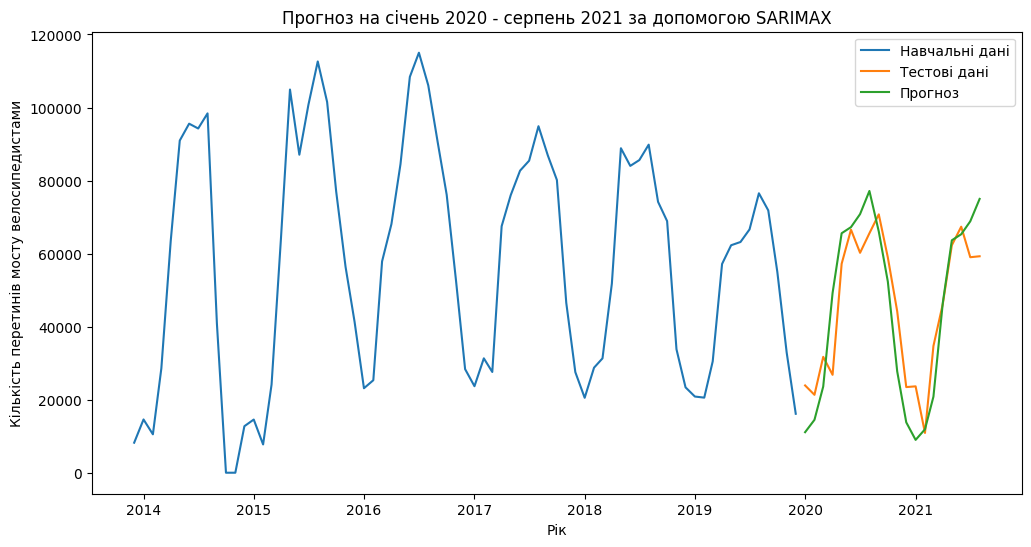

mean absolute percentage error =  0.2511031399386955
RMSE: 10684.925023552614


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Перевірка формату дат
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

# Навчальна вибірка до кінця 2019 року
train_data = filtered_data.loc[:'2019-12']
# Тестова вибірка на 2020 рік
test_data = filtered_data.loc['2020-01':'2021-08']

# Побудова SARIMA
model = SARIMAX(train_data['Count'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 12))
results = model.fit()

# Прогноз для 2020
start = len(train_data)
end = start + len(test_data) - 1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')

# Візуалізація
plt.figure(figsize=(12, 6))
plt.plot(train_data['Count'], label='Навчальні дані')
plt.plot(test_data['Count'], label='Тестові дані')
plt.plot(test_data.index, predictions, label='Прогноз')
plt.legend()
plt.title('Прогноз на січень 2020 - серпень 2021 за допомогою SARIMAX')
plt.xlabel('Рік')
plt.ylabel('Кількість перетинів мосту велосипедистами')
plt.show()

# Оцінка точності
mape = mean_absolute_percentage_error(test_data['Count'], predictions)
print('mean absolute percentage error = ', mape)
# Оцінка точності
error = rmse(test_data['Count'], predictions)
print(f'RMSE: {error}')


/tmp/ipython-input-3535330652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn

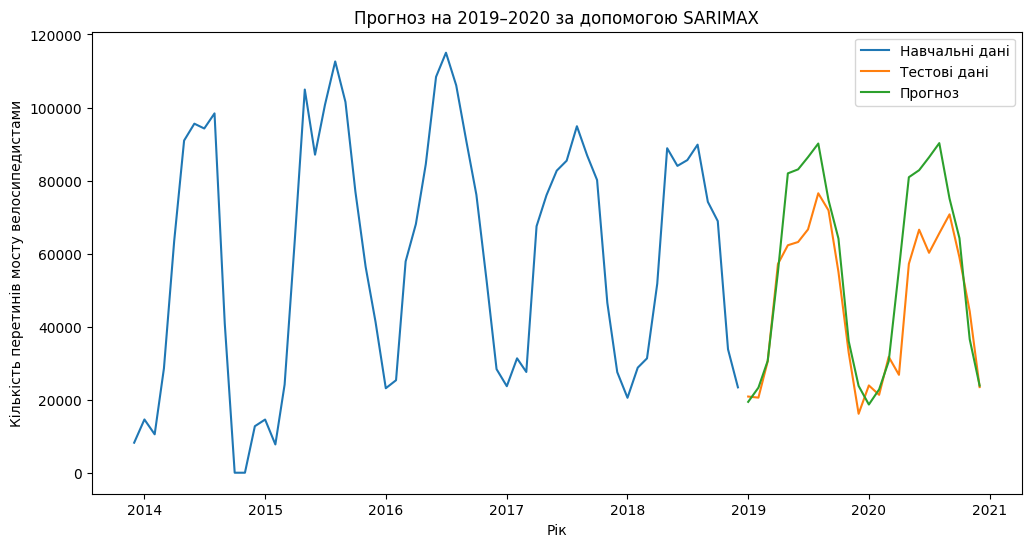

mean absolute percentage error =  0.2224871770153305


In [ ]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from sklearn.metrics import mean_absolute_percentage_error

# Перевірка формату дат
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

# Навчальна вибірка до кінця 2018 року
train_data = filtered_data.loc[:'2018-12']
# Тестова вибірка на 2019–2020 роки
test_data = filtered_data.loc['2019-01':'2020-12']

# Побудова SARIMA
model = SARIMAX(train_data['Count'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 12))
results = model.fit()

# Прогноз для 2019–2020
start = len(train_data)
end = start + len(test_data) - 1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')

# Візуалізація
plt.figure(figsize=(12, 6))
plt.plot(train_data['Count'], label='Навчальні дані')
plt.plot(test_data['Count'], label='Тестові дані')
plt.plot(test_data.index, predictions, label='Прогноз')
plt.legend()
plt.title('Прогноз на 2019–2020 за допомогою SARIMAX')
plt.xlabel('Рік')
plt.ylabel('Кількість перетинів мосту велосипедистами')
plt.show()

# Оцінка точності
mape = mean_absolute_percentage_error(test_data['Count'], predictions)
print('mean absolute percentage error = ', mape)


/tmp/ipython-input-1960224049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments wi

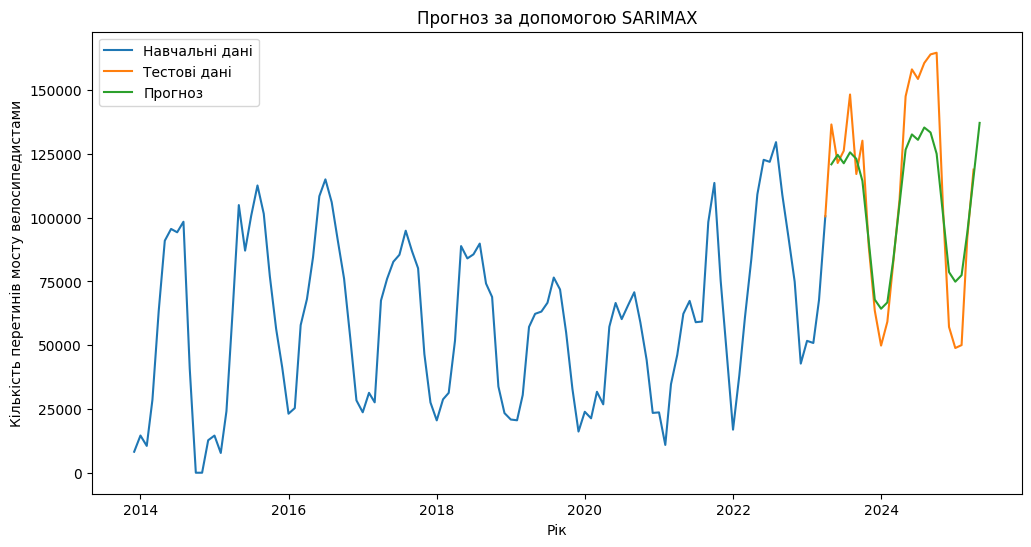

RMSE: 26237.189712464366
0.23494310377798666


In [ ]:
# Побудова SARIMA моделі
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

train_data = filtered_data.iloc[:len(filtered_data)-24]
test_data = filtered_data.iloc[len(filtered_data)-25:]


model = SARIMAX(train_data['Count'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

# Прогноз
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start, end, dynamic=False, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(train_data['Count'], label='Навчальні дані')
plt.plot(test_data['Count'], label='Тестові дані')
plt.plot(predictions, label='Прогноз')
plt.legend()
plt.title('Прогноз за допомогою SARIMAX')
plt.xlabel('Рік')
plt.ylabel('Кількість перетинів мосту велосипедистами')
plt.show()

# Оцінка точності
error = rmse(test_data['Count'], predictions)
print(f'RMSE: {error}')


from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(test_data['Count'], predictions))


In [ ]:
from scipy.stats import levene

# Перевірка на нормальний розподіл
stat, p1 = stats.shapiro(test_data['Count'])
stat, p2 = stats.shapiro(predictions)
print(f"Шапіро-Уїлка тест p1-значення: {p1}")
print(f"Шапіро-Уїлка тест p2-значення: {p2}")

# Виконання тесту Левена для перевірки рівності дисперсій
levene_stat, levene_p = stats.levene(test_data['Count'], predictions)

print(f"Левена тест p-значення: {levene_p}")

# Виконання тесту t-Стьюдента
if p1 > 0.05 or p2 > 0.05:
    log_test_data = np.log(test_data['Count'])
    log_predictions = np.log(predictions)
    t_stat, p_value = stats.ttest_rel(log_test_data, log_predictions)
else:
    t_stat, p_value = stats.ttest_rel(test_data['Count'], predictions)

#print(f"t-статистика: {t_stat}")
print(f"T-тест Стюдента p-значення: {p_value}")

# Аналіз результатів тесту
alpha = 0.05
if p_value < alpha:
    print("Існують статистично значущі відмінності між прогнозами та тестовими даними.")
else:
    print("Немає статистично значущих відмінностей між прогнозами та тестовими даними.")


Шапіро-Уїлка тест p1-значення: 0.06447252659858575
Шапіро-Уїлка тест p2-значення: 0.009580408895788086
Левена тест p-значення: 0.024473770446448852
T-тест Стюдента p-значення: 0.7796556183479671
Немає статистично значущих відмінностей між прогнозами та тестовими даними.


Для презентації:

Тестування моделі до серпня 2021 року включно

In [ ]:
# Перевірка формату дат
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)
#нові навчальні дані
filtered_data_new = filtered_data.loc[:'2021-08']


# Навчальна вибірка до кінця 2018 року
train_data_new = filtered_data.loc[:'2018-12']
# Тестова вибірка на 2019–2020 роки
test_data_new = filtered_data.loc['2019-01':'2020-12']


In [ ]:
# Є сезонність, треба перетворити у стаціонарний шляхом диференціювання
# --- Стаціонарність: перетворення ---

series_new = filtered_data_new['Count'].dropna()
max_diff = 5 # максимум 5 диференціювань

for d in range(max_diff + 1):
    if d > 0:
        series_diff = series_new.diff(d).dropna()
    else:
        series_diff = series_new
    result = adfuller(series_diff)
    p_value = result[1]
    print(f'd = {d}, p-value = {p_value}')
    if p_value < 0.05:
        print(f'✅ Стаціонарність досягнута при d = {d}')
        break
else:
    print('⚠️ Ряд не стає стаціонарним до 5-го диференціювання')

d = 0, p-value = 0.3920983554216909
d = 1, p-value = 1.3621595561269115e-09
✅ Стаціонарність досягнута при d = 1


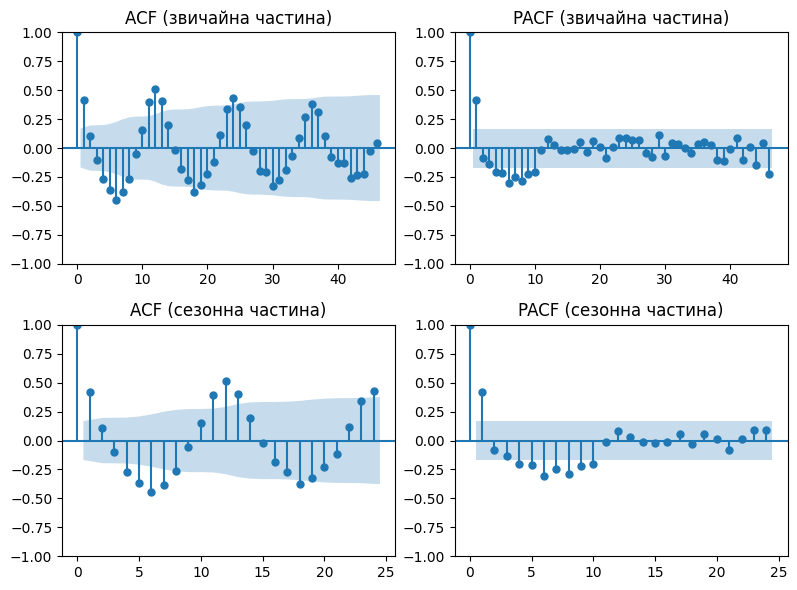

In [26]:
# Побудова ACF та PACF графіків
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# ACF та PACF для звичайної частини
plot_acf(series_diff, ax=axes[0, 0], lags=46)
axes[0, 0].set_title('ACF (звичайна частина)')
plot_pacf(series_diff, ax=axes[0, 1], lags=46, method='ywm')
axes[0, 1].set_title('PACF (звичайна частина)')

# ACF та PACF для сезонної частини — лаги кратні сезонност!
seasonal_lag = 12  # річна сезонність
plot_acf(series_diff, ax=axes[1, 0], lags=seasonal_lag*2)
axes[1, 0].set_title('ACF (сезонна частина)')
plot_pacf(series_diff, ax=axes[1, 1], lags=seasonal_lag*2, method='ywm')
axes[1, 1].set_title('PACF (сезонна частина)')

plt.tight_layout()
plt.show()

In [ ]:
p1 = 1  # значущі піки звич ак
q1 = 2  # значущі піки звич чак
d1 = 1
P1 = 1  # значущі піки на лагах кратних сезонності ак
Q1 = 1  # значущі піки на лагах кратних сезонності чак
D1 = 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt
from scipy import stats

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


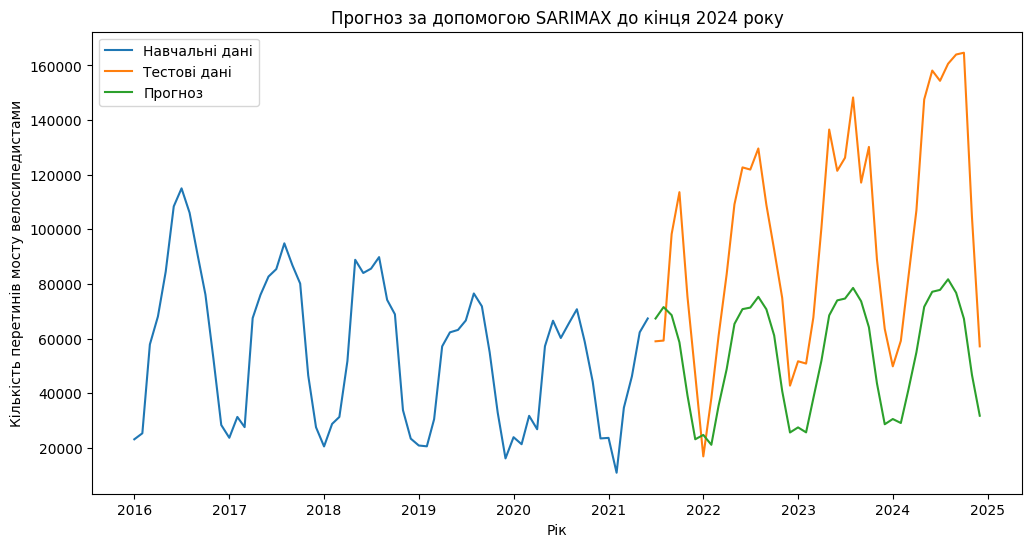

RMSE: 49222.13338868296
MAPE 0.4446055680394602
SARIMA - Короткий горизонт: {'RMSE': np.float64(38830.045199897686), 'MAE': 35845.729429309264, 'MAPE': 0.4312375499675194}
SARIMA - Весь період: {'RMSE': np.float64(50383.132218226216), 'MAE': 45694.41663317339, 'MAPE': 0.45812984525407785}
SARIMA - Повний тестовий період (2021-07 – 2024-12): {'RMSE': np.float64(49222.13338868296), 'MAE': 44009.07659810219, 'MAPE': 0.4446055680394602}


In [ ]:
# Побудова SARIMA моделі
# Перевірка формату дат
filtered_data['YearMonth_datetime'] = pd.to_datetime(filtered_data['YearMonth'])
filtered_data.set_index('YearMonth_datetime', inplace=True)

# Навчальна вибірка до червня 2021 року
train_data = filtered_data.loc[:'2021-06']
# Тестова вибірка до 2024 року
test_data = filtered_data.loc['2021-07':'2024-12']


model = SARIMAX(train_data['Count'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

# Прогноз
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start, end, dynamic=False, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(train_data['Count'], label='Навчальні дані')
plt.plot(test_data['Count'], label='Тестові дані')
plt.plot(predictions, label='Прогноз')
plt.legend()
plt.title('Прогноз за допомогою SARIMAX до кінця 2024 року')
plt.xlabel('Рік')
plt.ylabel('Кількість перетинів мосту велосипедистами')
plt.show()

# Оцінка точності
error = rmse(test_data['Count'], predictions)
print(f'RMSE: {error}')


from sklearn.metrics import mean_absolute_percentage_error
print('MAPE', mean_absolute_percentage_error(test_data['Count'], predictions))


predictions.index = test_data.index

# Підперіоди
short_start = '2021-09'
short_end = '2022-08'
full_post_start = '2021-09'
full_post_end = '2024-12'

short_actual = test_data.loc[short_start:short_end, 'Count']
short_pred = predictions.loc[short_start:short_end]

full_post_actual = test_data.loc[full_post_start:full_post_end, 'Count']
full_post_pred = predictions.loc[full_post_start:full_post_end]

# Функція для розрахунку метрик
def calculate_metrics(actual, pred):
    rmse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)
    return {'RMSE': np.sqrt(rmse), 'MAE': mae, 'MAPE': mape}

# Метрики для SARIMA
sarima_short_metrics = calculate_metrics(short_actual, short_pred)
sarima_full_metrics = calculate_metrics(full_post_actual, full_post_pred)

print("SARIMA - Короткий горизонт:", sarima_short_metrics)
print("SARIMA - Весь період:", sarima_full_metrics)

full_test_metrics = calculate_metrics(test_data['Count'], predictions)
print("SARIMA - Повний тестовий період (2021-07 – 2024-12):", full_test_metrics)

In [ ]:
#Seasonal Naive
# Крок 1: Витягуємо останнє значення для кожного місяця з train_data
train_months = train_data.index.month
last_values = {}
for m in range(1, 13):
    month_dates = train_data.index[train_months == m]
    if len(month_dates) > 0:
        last_date = month_dates.max()
        last_values[m] = train_data.loc[last_date, 'Count']

# Крок 2: Генеруємо прогнози для test_data
naive_predictions = pd.Series([last_values.get(m, np.nan) for m in test_data.index.month], index=test_data.index)

# Крок 3: Функція для метрик (як у попередньому коді)
def calculate_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Крок 4: Метрики для повного тестового періоду
naive_full_metrics = calculate_metrics(test_data['Count'], naive_predictions)
print("Seasonal Naive - Повний тестовий період:", naive_full_metrics)

# Для підперіодів
short_start = '2021-09'
short_end = '2022-08'
short_actual = test_data.loc[short_start:short_end, 'Count']
naive_short_metrics = calculate_metrics(short_actual, naive_predictions.loc[short_start:short_end])

full_post_start = '2021-09'
full_post_end = '2024-12'
full_post_actual = test_data.loc[full_post_start:full_post_end, 'Count']
naive_full_post_metrics = calculate_metrics(full_post_actual, naive_predictions.loc[full_post_start:full_post_end])

print("Seasonal Naive - Короткий горизонт:", naive_short_metrics)
print("Seasonal Naive - Післяінтервенційний період:", naive_full_post_metrics)

Seasonal Naive - Повний тестовий період: {'RMSE': np.float64(55456.9791080051), 'MAE': 49227.119047619046, 'MAPE': 0.49932155000057826}
Seasonal Naive - Короткий горизонт: {'RMSE': np.float64(42128.99237461062), 'MAE': 38523.5, 'MAPE': 0.4623091133772981}
Seasonal Naive - Післяінтервенційний період: {'RMSE': np.float64(56817.4517727608), 'MAE': 51500.85, 'MAPE': 0.521119979084806}


In [ ]:
# ETS Exponential Smoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Припускаємо train_data і test_data готові

# Крок 1: Побудова ETS моделі
ets_model = ETSModel(train_data['Count'], error='add', trend='add', seasonal='add', seasonal_periods=12)

# Крок 2: Фіттинг
ets_results = ets_model.fit()

# Крок 3: Прогноз на кількість кроків тестових даних
ets_predictions = ets_results.forecast(steps=len(test_data))
ets_predictions.index = test_data.index  # Вирівнювання індексів

# Крок 4: Метрики (та сама функція)
ets_full_metrics = calculate_metrics(test_data['Count'], ets_predictions)
print("ETS - Повний тестовий період:", ets_full_metrics)

# Для підперіодів
ets_short_metrics = calculate_metrics(short_actual, ets_predictions.loc[short_start:short_end])
ets_full_post_metrics = calculate_metrics(full_post_actual, ets_predictions.loc[full_post_start:full_post_end])

print("ETS - Короткий горизонт:", ets_short_metrics)
print("ETS - Післяінтервенційний період:", ets_full_post_metrics)

ETS - Повний тестовий період: {'RMSE': np.float64(81635.71406801985), 'MAE': 73113.66617864302, 'MAPE': 0.7590274521498375}
ETS - Короткий горизонт: {'RMSE': np.float64(51448.01451037054), 'MAE': 46949.49064043808, 'MAPE': 0.5469221450190408}
ETS - Післяінтервенційний період: {'RMSE': np.float64(83640.23635999869), 'MAE': 76507.50378125501, 'MAPE': 0.7925576752499536}


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# порівняння з бенчммарком
# Таблиця порівняння
metrics_data = {
    'Model': ['SARIMA', 'Seasonal Naive', 'ETS'],
    'Short RMSE': [sarima_short_metrics['RMSE'], naive_short_metrics['RMSE'], ets_short_metrics['RMSE']],
    'Short MAE': [sarima_short_metrics['MAE'], naive_short_metrics['MAE'], ets_short_metrics['MAE']],
    'Short MAPE': [sarima_short_metrics['MAPE'], naive_short_metrics['MAPE'], ets_short_metrics['MAPE']],
    'Full RMSE': [sarima_full_metrics['RMSE'], naive_full_metrics['RMSE'], ets_full_metrics['RMSE']],
    'Full MAE': [sarima_full_metrics['MAE'], naive_full_metrics['MAE'], ets_full_metrics['MAE']],
    'Full MAPE': [sarima_full_metrics['MAPE'], naive_full_metrics['MAPE'], ets_full_metrics['MAPE']]
}

comparison_table = pd.DataFrame(metrics_data)
print(comparison_table)

            Model    Short RMSE     Short MAE  Short MAPE     Full RMSE  \
0          SARIMA  38830.045200  35845.729429    0.431238  50383.132218   
1  Seasonal Naive  42128.992375  38523.500000    0.462309  55456.979108   
2             ETS  51448.014510  46949.490640    0.546922  81635.714068   

       Full MAE  Full MAPE  
0  45694.416633   0.458130  
1  49227.119048   0.499322  
2  73113.666179   0.759027  


DM-and CUSUM/CUSUMSQ

Diebold-Mariano statistic: -1.1545, p-value: 0.2483


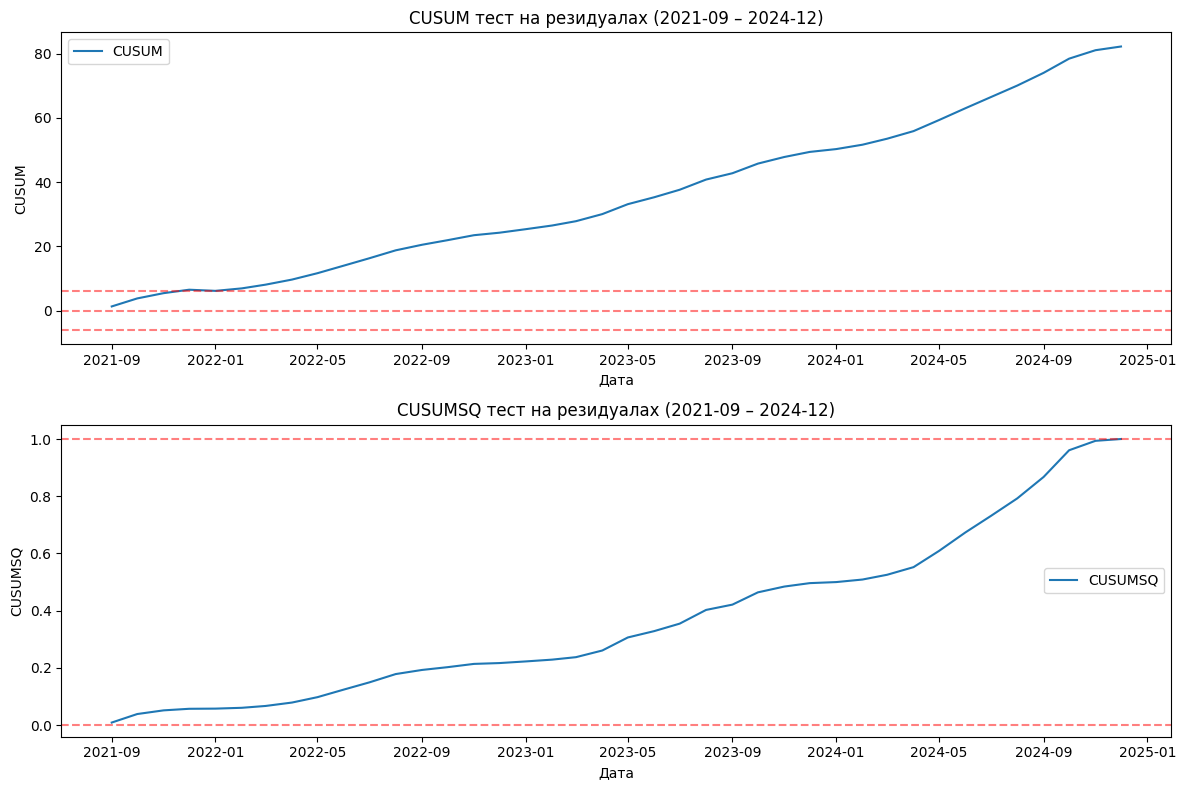

In [ ]:
# Перевірка вирівнювання індексів
assert predictions.index.equals(test_data.index), "Індекси predictions і test_data не вирівняні!"

# Періоди для аналізу
short_start = '2021-09'
short_end = '2022-08'
post_start = '2022-09'
full_post_start = '2021-09'
full_post_end = '2024-12'

# Вибірка даних для періодів
short_actual = test_data.loc[short_start:short_end, 'Count']
short_pred = predictions.loc[short_start:short_end]
post_actual = test_data.loc[post_start:full_post_end, 'Count']
post_pred = predictions.loc[post_start:full_post_end]
full_post_actual = test_data.loc[full_post_start:full_post_end, 'Count']
full_post_pred = predictions.loc[full_post_start:full_post_end]

# 1. Diebold-Mariano тест
def dm_test(losses1, losses2, h=1):
    """
    Diebold-Mariano тест для порівняння середніх втрат двох періодів.
    losses1, losses2: масиви втрат (наприклад, MSE) для двох періодів.
    h: максимальна кількість лагів для HAC-корекції.
    Повертає: DM-статистику і p-value.
    """
    d = losses1 - losses2[:len(losses1)] if len(losses1) < len(losses2) else losses1[:len(losses2)] - losses2
    mean_d = np.mean(d)
    # HAC оцінка дисперсії з Newey-West
    model = sm.OLS(d, np.ones(len(d)))
    hac_result = model.fit(cov_type='HAC', cov_kwds={'maxlags': h})
    var_d = hac_result.bse[0]**2 * len(d)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))
    return dm_stat, p_value

# Обчислення втрат (MSE) для pre і post періодів
losses_pre = (short_actual - short_pred)**2
losses_post = (post_actual - post_pred)**2

# Виконання DM тесту
dm_stat, dm_p = dm_test(losses_pre.values, losses_post.values, h=1)
print(f"Diebold-Mariano statistic: {dm_stat:.4f}, p-value: {dm_p:.4f}")

# 2. CUSUM і CUSUMSQ тести
# Резидуали для післяінтервенційного періоду
resid_post = full_post_actual - full_post_pred
T = len(resid_post)

# CUSUM
cusum = np.cumsum(resid_post) / np.std(resid_post)

# CUSUMSQ
cusumsq = np.cumsum(resid_post**2) / np.sum(resid_post**2)

# Довірчі межі для CUSUM (приблизно ±0.948 * sqrt(T) для 5% рівня значущості)
c = 0.948  # Константа для 5% рівня значущості
conf_bound = c * np.sqrt(T)

# Візуалізація
plt.figure(figsize=(12, 8))

# Графік CUSUM
plt.subplot(2, 1, 1)
plt.plot(resid_post.index, cusum, label='CUSUM')
plt.axhline(0, color='r', linestyle='--', alpha=0.5)
plt.axhline(conf_bound, color='r', linestyle='--', alpha=0.5)
plt.axhline(-conf_bound, color='r', linestyle='--', alpha=0.5)
plt.title('CUSUM тест на резидуалах (2021-09 – 2024-12)')
plt.xlabel('Дата')
plt.ylabel('CUSUM')
plt.legend()

# Графік CUSUMSQ
plt.subplot(2, 1, 2)
plt.plot(resid_post.index, cusumsq, label='CUSUMSQ')
plt.axhline(0, color='r', linestyle='--', alpha=0.5)
plt.axhline(1, color='r', linestyle='--', alpha=0.5)
plt.title('CUSUMSQ тест на резидуалах (2021-09 – 2024-12)')
plt.xlabel('Дата')
plt.ylabel('CUSUMSQ')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# DM-тест виявився не значущим через малий обсяг даних
# CUMSUM підтверджує значущий зсув у даних

Бруклін-Манхетен DID

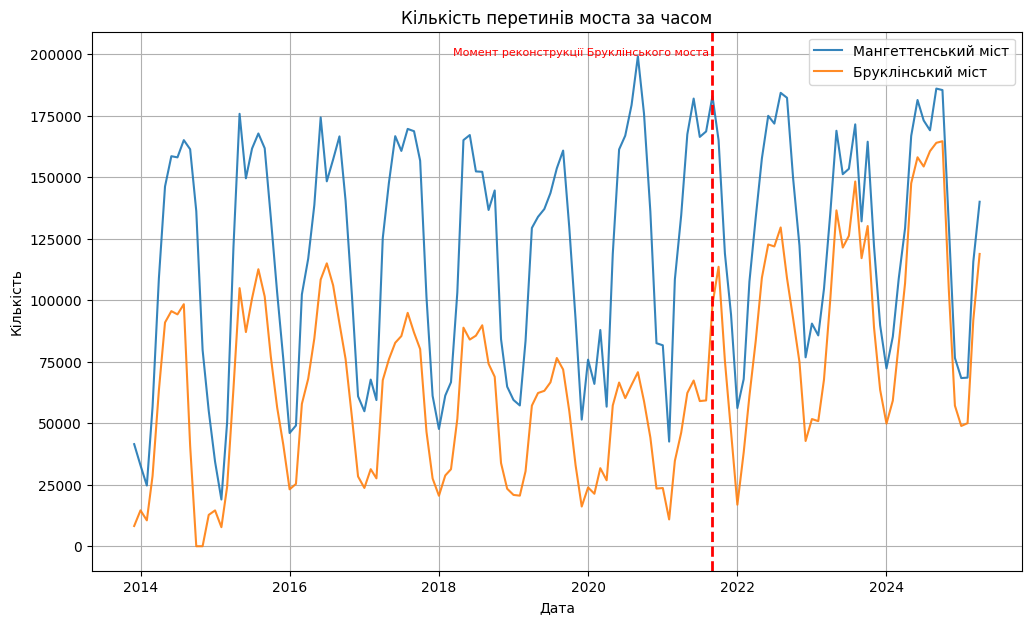

In [32]:
# пересвідчитись, чи графіки паралельні для DiD
plot_count_over_time_by_name(df, names = ["Manhattan Bridge Bike Comprehensive", "Comprehensive Brooklyn Bridge Counter"])


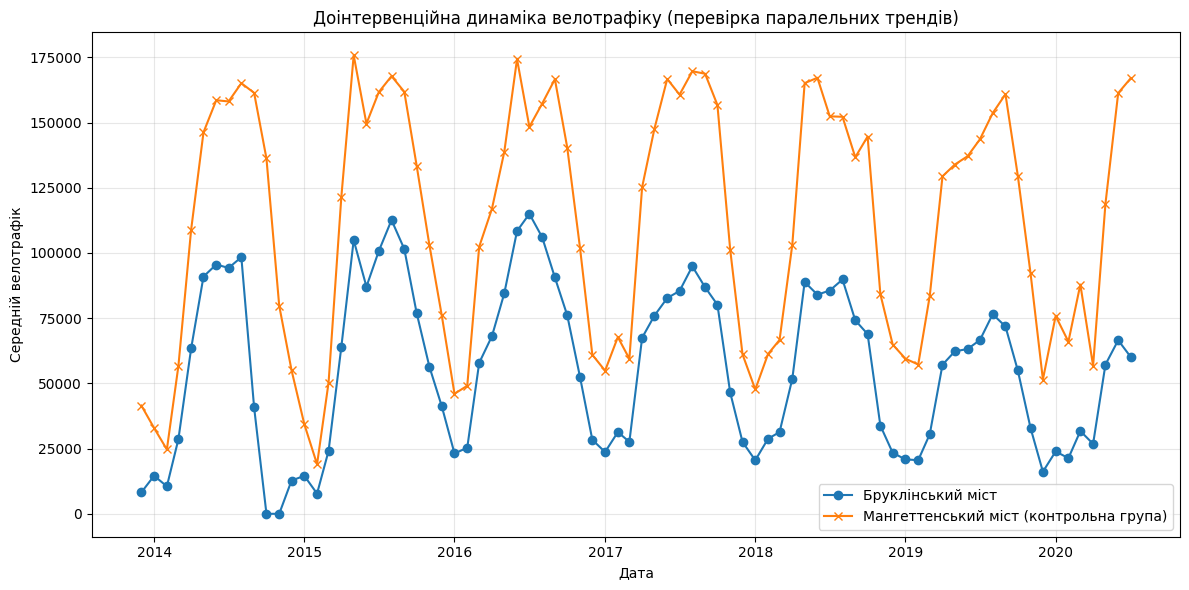

In [31]:
#Візуалізуємо паралельність трендів (до липня 2020), бо далі вплив ковіду

# Параметри
treated_unit = 'Comprehensive Brooklyn Bridge Counter'
control_unit = 'Manhattan Bridge Bike Comprehensive'
intervention_date = pd.to_datetime('2020-08-01')

# Фільтруємо доінтервенційний період
df['Date'] = pd.to_datetime(df['Date'])
pre_df = df[df['Date'] < intervention_date]

# Агрегуємо середні значення за місяць для кожного моста
mean_pre = pre_df.groupby(['Date', 'Name'])['Count'].mean().reset_index()

# Розділяємо на групи
treated = mean_pre[mean_pre['Name'] == treated_unit]
control = mean_pre[mean_pre['Name'] == control_unit]

# Побудова графіка
plt.figure(figsize=(12, 6))
plt.plot(treated['Date'], treated['Count'], label='Бруклінський міст', marker='o')
plt.plot(control['Date'], control['Count'], label='Мангеттенський міст (контрольна група)', marker='x')

plt.title('Доінтервенційна динаміка велотрафіку (перевірка паралельних трендів)')
plt.xlabel('Дата')
plt.ylabel('Середній велотрафік')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

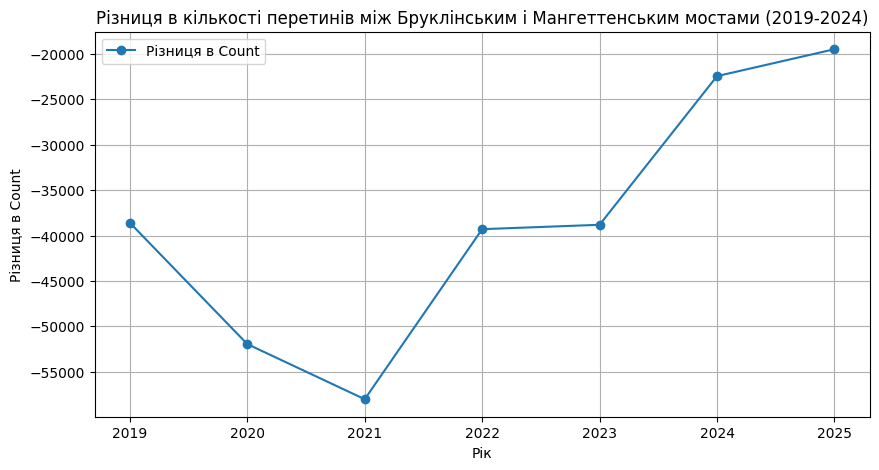

In [33]:
# Фільтрація даних з листопада 2018 року (початок з 2019 року для річних даних)
df_post_oct_2018 = df[df['Year'] >= 2019]

# Обчислення різниці для кожного року
years = df_post_oct_2018['Year'].unique()
diff_values = []
for year in years:
    brooklyn_count = df_post_oct_2018[(df_post_oct_2018['Year'] == year) &
                                     (df_post_oct_2018['Name'] == "Comprehensive Brooklyn Bridge Counter")]['Count']
    manhattan_count = df_post_oct_2018[(df_post_oct_2018['Year'] == year) &
                                      (df_post_oct_2018['Name'] == "Manhattan Bridge Bike Comprehensive")]['Count']
    if not brooklyn_count.empty and not manhattan_count.empty:
        diff = brooklyn_count.iloc[0] - manhattan_count.iloc[0]
        diff_values.append(diff)

# Створення серії з різницею
df_diff = pd.Series(diff_values, index=years).dropna()

# Візуалізація різниці
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df_diff.index, df_diff.values, label='Різниця в Count', marker='o')
plt.title('Різниця в кількості перетинів між Бруклінським і Мангеттенським мостами (2019-2024)')
plt.xlabel('Рік')
plt.ylabel('Різниця в Count')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Налаштування графіки
#plt.style.use('seaborn-v0_8')
#sns.set_palette("husl")

class DiDAnalysis:
    def __init__(self, df):
        """
        Ініціалізація з DataFrame
        df має містити колонки: 'Name', 'Count', 'Year', 'Month'
        """
        self.df = df.copy()
        self.prepare_data()

    def prepare_data(self):
        """Етап 1: Підготовка даних"""
        print("=== ЕТАП 1: ПІДГОТОВКА ДАНИХ ===")

        # Створюємо дату
        self.df['Date'] = pd.to_datetime(self.df[['Year', 'Month']].assign(day=1))

        # Фільтруємо лише потрібні мости
        brooklyn_names = ['Comprehensive Brooklyn Bridge Counter']
        manhattan_names = ['Manhattan Bridge Bike Comprehensive']

        self.df_filtered = self.df[
            (self.df['Name'].isin(brooklyn_names + manhattan_names)) &
            (self.df['Date'] >= '2013-12-01') &
            (self.df['Date'] <= '2024-12-31')
        ].copy()

        # Перевіряємо та конвертуємо Count до числового типу
        self.df_filtered['Count'] = pd.to_numeric(self.df_filtered['Count'], errors='coerce')
        if self.df_filtered['Count'].isna().any():
            print("Попередження: Знайдені нечислові значення в 'Count'. Замінюємо NaN на середнє.")
            self.df_filtered['Count'] = self.df_filtered['Count'].fillna(self.df_filtered['Count'].mean())

        # Створюємо стандартизовані назви
        self.df_filtered['Bridge'] = self.df_filtered['Name'].map({
            'Comprehensive Brooklyn Bridge Counter': 'Brooklyn',
            'Manhattan Bridge Bike Comprehensive': 'Manhattan'
        })

        # Створюємо індикатори
        self.df_filtered['Treatment'] = (self.df_filtered['Bridge'] == 'Brooklyn').astype(int)
        self.df_filtered['Post'] = (self.df_filtered['Date'] >= '2021-10-01').astype(int)  # Виправлено на жовтень для точності
        self.df_filtered['DiD'] = self.df_filtered['Treatment'] * self.df_filtered['Post']

        # Додаємо контроли
        self.df_filtered['Time_Trend'] = range(len(self.df_filtered))
        self.df_filtered['Month_Num'] = self.df_filtered['Date'].dt.month
        self.df_filtered['COVID'] = ((self.df_filtered['Date'] >= '2020-03-01') &
                                   (self.df_filtered['Date'] <= '2021-09-30')).astype(int)

        # Сезонні індикатори
        for month in range(1, 13):
            self.df_filtered[f'Month_{month}'] = (self.df_filtered['Month_Num'] == month).astype(int)

        print(f"Дані підготовлено: {len(self.df_filtered)} спостережень")
        print(f"Періоди: {self.df_filtered['Date'].min()} - {self.df_filtered['Date'].max()}")
        print(f"Brooklyn спостережень: {self.df_filtered[self.df_filtered['Bridge']=='Brooklyn'].shape[0]}")
        print(f"Manhattan спостережень: {self.df_filtered[self.df_filtered['Bridge']=='Manhattan'].shape[0]}")


    ##################################################################################################################
    def test_parallel_trends(self):
        """Етап 2: Тестування паралельних трендів"""
        print("\n=== ЕТАП 2: ТЕСТУВАННЯ ПАРАЛЕЛЬНИХ ТРЕНДІВ ===")

        # Фільтруємо pre-treatment період (до вересня 2021)
        pre_data = self.df_filtered[
            (self.df_filtered['Date'] >= '2013-12-01') &
            (self.df_filtered['Date'] <= '2020-07-31')
        ].copy()

        # Створюємо тренди по місяцях
        pre_data = pre_data.sort_values(['Bridge', 'Date'])
        pre_data['Time'] = pre_data.groupby('Bridge').cumcount()

        # Регресія для тестування паралельних трендів
        X = pd.get_dummies(pre_data[['Treatment', 'Time']], drop_first=False)
        X['Treatment_Time'] = pre_data['Treatment'] * pre_data['Time']

        # Додаємо сезонні контролю
        month_dummies = pd.get_dummies(pre_data['Month_Num'], prefix='Month', drop_first=True)
        X = pd.concat([X, month_dummies], axis=1)

        # Конвертуємо до числового формату та додаємо константу
        X = X.astype(float)
        X = sm.add_constant(X)

        # Перевіряємо типи даних
        print("Типи даних у X:", X.dtypes)
        print("Тип даних у Count:", pre_data['Count'].dtype)

        model = sm.OLS(pre_data['Count'].astype(float), X).fit()

        print("Результати тесту паралельних трендів:")
        print(f"Коефіцієнт Treatment_Time: {model.params['Treatment_Time']:.4f}")
        print(f"p-value: {model.pvalues['Treatment_Time']:.4f}")

        if model.pvalues['Treatment_Time'] > 0.05:
            print("✓ Паралельні тренди підтверджуються (p > 0.05)")
        else:
            print("✗ Паралельні тренди порушуються (p <= 0.05)")

        # Візуалізація трендів
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Сирі дані
        for bridge in ['Brooklyn', 'Manhattan']:
            bridge_data = pre_data[pre_data['Bridge'] == bridge]
            ax1.plot(bridge_data['Date'], bridge_data['Count'],
                    marker='o', label=f'{bridge} Bridge', alpha=0.7)

        ax1.axvline(x=pd.to_datetime('2021-09-01'), color='red',
                   linestyle='--', alpha=0.7, label='Treatment')
        ax1.set_title('Динаміка велотрафіку (Pre-treatment)')
        ax1.set_xlabel('Дата')
        ax1.set_ylabel('Кількість велосипедистів')
        ax1.legend()
        ax1.tick_params(axis='x', rotation=45)

        # Детрендовані дані
        for bridge in ['Brooklyn', 'Manhattan']:
            bridge_data = pre_data[pre_data['Bridge'] == bridge]
            X_trend = sm.add_constant(bridge_data['Time'])
            trend_model = sm.OLS(bridge_data['Count'].astype(float), X_trend).fit()
            detrended = bridge_data['Count'] - trend_model.predict(X_trend)
            ax2.plot(bridge_data['Date'], detrended,
                    marker='o', label=f'{bridge} Bridge (detrended)', alpha=0.7)

        ax2.set_title('Детрендовані дані (Pre-treatment)')
        ax2.set_xlabel('Дата')
        ax2.set_ylabel('Детрендований велотрафік')
        ax2.legend()
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        return model

    # Інші методи (basic_did_estimation, dynamic_did, robustness_checks, placebo_tests, generate_report)
    # залишаються без змін, але я додам їх нижче для повноти

    def basic_did_estimation(self):
        """Етап 3: Базова DiD оцінка"""
        print("\n=== ЕТАП 3: БАЗОВА DiD ОЦІНКА ===")

        # Основна DiD регресія
        X = pd.get_dummies(self.df_filtered[['Treatment', 'Post', 'DiD']], drop_first=False)

        # Додаємо сезонні контроли
        month_dummies = pd.get_dummies(self.df_filtered['Month_Num'], prefix='Month', drop_first=True)
        X = pd.concat([X, month_dummies], axis=1)

        # COVID контроль
        X['COVID'] = self.df_filtered['COVID']
        X = X.astype(float)  # Конвертація до числового типу
        X = sm.add_constant(X)

        model = sm.OLS(self.df_filtered['Count'].astype(float), X).fit(cov_type='HC3')  # Robust SE

        print("Результати базової DiD регресії:")
        print(model.summary().tables[1])

        # Витягуємо ключові коефіцієнти
        did_effect = model.params['DiD']
        did_se = model.bse['DiD']
        did_pvalue = model.pvalues['DiD']

        print(f"\n=== КЛЮЧОВІ РЕЗУЛЬТАТИ ===")
        print(f"DiD ефект: {did_effect:.2f} велосипедистів на місяць")
        print(f"Стандартна помилка: {did_se:.2f}")
        print(f"95% довірчий інтервал: [{did_effect - 1.96*did_se:.2f}, {did_effect + 1.96*did_se:.2f}]")
        print(f"p-value: {did_pvalue:.4f}")

        if did_pvalue < 0.05:
            print("✓ Ефект статистично значущий")
        else:
            print("✗ Ефект статистично незначущий")

        # Візуалізація результатів
        self.plot_did_results()

        return model

    def plot_did_results(self):
        """Візуалізація DiD результатів"""
        # Середні значення по групах та періодах
        means = self.df_filtered.groupby(['Bridge', 'Post'])['Count'].mean().unstack()

        # DiD розрахунок
        brooklyn_diff = means.loc['Brooklyn', 1] - means.loc['Brooklyn', 0]
        manhattan_diff = means.loc['Manhattan', 1] - means.loc['Manhattan', 0]
        did_effect = brooklyn_diff - manhattan_diff

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Часовий ряд
        for bridge in ['Brooklyn', 'Manhattan']:
            bridge_data = self.df_filtered[self.df_filtered['Bridge'] == bridge]
            bridge_data = bridge_data.sort_values('Date')
            ax1.plot(bridge_data['Date'], bridge_data['Count'],
                    marker='o', label=f'{bridge} Bridge', alpha=0.7, linewidth=2)

        ax1.axvline(x=pd.to_datetime('2021-09-01'), color='red',
                   linestyle='--', linewidth=2, label='Treatment Date')
        ax1.set_title('Велотрафік до та після реконструкції')
        ax1.set_xlabel('Дата')
        ax1.set_ylabel('Кількість велосипедистів')
        ax1.legend()
        ax1.tick_params(axis='x', rotation=45)

        # DiD діаграма
        periods = ['Pre-treatment', 'Post-treatment']
        brooklyn_vals = [means.loc['Brooklyn', 0], means.loc['Brooklyn', 1]]
        manhattan_vals = [means.loc['Manhattan', 0], means.loc['Manhattan', 1]]

        ax2.plot(periods, brooklyn_vals, marker='o', linewidth=3,
                markersize=8, label='Brooklyn (Treatment)')
        ax2.plot(periods, manhattan_vals, marker='s', linewidth=3,
                markersize=8, label='Manhattan (Control)')

        # Контрфактуальна лінія
        brooklyn_counterfactual = means.loc['Brooklyn', 0] + manhattan_diff
        ax2.plot(periods, [means.loc['Brooklyn', 0], brooklyn_counterfactual],
                'r--', alpha=0.7, linewidth=2, label='Brooklyn Counterfactual')

        ax2.set_title(f'DiD Ефект: {did_effect:.0f} велосипедистів/місяць')
        ax2.set_ylabel('Середня кількість велосипедистів')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()



    def robustness_checks(self):
        """Етап 4: Тести на робастність"""
        print("\n=== ЕТАП 4: ТЕСТИ НА РОБАСТНІСТЬ ===")

        results = {}

        # 1. Альтернативні точки розділу
        print("\n1. Альтернативні точки розділу:")
        alternative_dates = ['2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01']

        for date in alternative_dates:
            df_temp = self.df_filtered.copy()
            df_temp['Post_Alt'] = (df_temp['Date'] >= date).astype(int)
            df_temp['DiD_Alt'] = df_temp['Treatment'] * df_temp['Post_Alt']

            X = pd.get_dummies(df_temp[['Treatment', 'Post_Alt', 'DiD_Alt']], drop_first=False)
            month_dummies = pd.get_dummies(df_temp['Month_Num'], prefix='Month', drop_first=True)
            X = pd.concat([X, month_dummies], axis=1)
            X['COVID'] = df_temp['COVID']
            X = X.astype(float)
            X = sm.add_constant(X)

            model = sm.OLS(df_temp['Count'].astype(float), X).fit(cov_type='HC3')
            effect = model.params['DiD_Alt']
            pvalue = model.pvalues['DiD_Alt']

            results[f'Cutoff_{date}'] = {'effect': effect, 'pvalue': pvalue}
            print(f"   {date}: Ефект = {effect:.2f}, p-value = {pvalue:.4f}")

        # 2. Виключення COVID періоду
        print("\n2. Виключення COVID періоду:")
        df_no_covid = self.df_filtered[
            (self.df_filtered['Date'] < '2020-03-01') |
            (self.df_filtered['Date'] > '2021-09-30')
        ].copy()

        if len(df_no_covid) > 100:  # Достатньо спостережень
            X = pd.get_dummies(df_no_covid[['Treatment', 'Post', 'DiD']], drop_first=False)
            month_dummies = pd.get_dummies(df_no_covid['Month_Num'], prefix='Month', drop_first=True)
            X = pd.concat([X, month_dummies], axis=1)
            X = X.astype(float)
            X = sm.add_constant(X)

            model = sm.OLS(df_no_covid['Count'].astype(float), X).fit(cov_type='HC3')
            effect = model.params['DiD']
            pvalue = model.pvalues['DiD']

            results['No_COVID'] = {'effect': effect, 'pvalue': pvalue}
            print(f"   Без COVID: Ефект = {effect:.2f}, p-value = {pvalue:.4f}")

        # 3. Тільки сезон весна-літо
        print("\n3. Тільки весна-літо (березень-серпень):")
        df_season = self.df_filtered[
            self.df_filtered['Month_Num'].isin([3, 4, 5, 6, 7, 8])
        ].copy()

        X = pd.get_dummies(df_season[['Treatment', 'Post', 'DiD']], drop_first=False)
        month_dummies = pd.get_dummies(df_season['Month_Num'], prefix='Month', drop_first=True)
        X = pd.concat([X, month_dummies], axis=1)
        X['COVID'] = df_season['COVID']
        X = X.astype(float)
        X = sm.add_constant(X)

        model = sm.OLS(df_season['Count'].astype(float), X).fit(cov_type='HC3')
        effect = model.params['DiD']
        pvalue = model.pvalues['DiD']

        results['Spring_Summer'] = {'effect': effect, 'pvalue': pvalue}
        print(f"   Весна-літо: Ефект = {effect:.2f}, p-value = {pvalue:.4f}")

        return results


    def generate_report(self):
        """Етап 5: Підсумковий звіт"""
        print("\n=== ЕТАП 5: ПІДСУМКОВИЙ ЗВІТ ===")

        # Повторюємо основну оцінку для звіту
        X = pd.get_dummies(self.df_filtered[['Treatment', 'Post', 'DiD']], drop_first=False)
        month_dummies = pd.get_dummies(self.df_filtered['Month_Num'], prefix='Month', drop_first=True)
        X = pd.concat([X, month_dummies], axis=1)
        X['COVID'] = self.df_filtered['COVID']
        X = X.astype(float)
        X = sm.add_constant(X)

        model = sm.OLS(self.df_filtered['Count'].astype(float), X).fit(cov_type='HC3')

        did_effect = model.params['DiD']
        did_se = model.bse['DiD']
        did_pvalue = model.pvalues['DiD']

        # Розрахунок описової статистики
        pre_brooklyn = self.df_filtered[
            (self.df_filtered['Bridge'] == 'Brooklyn') & (self.df_filtered['Post'] == 0)
        ]['Count'].mean()

        print("="*60)
        print("ПІДСУМКОВИЙ ЗВІТ DiD АНАЛІЗУ")
        print("="*60)
        print(f"Досліджуваний період: {self.df_filtered['Date'].min().strftime('%Y-%m')} - "
              f"{self.df_filtered['Date'].max().strftime('%Y-%m')}")
        print(f"Treatment група: Brooklyn Bridge")
        print(f"Control група: Manhattan Bridge")
        print(f"Дата втручання: Вересень 2021")
        print()
        print("ОСНОВНІ РЕЗУЛЬТАТИ:")
        print(f"• DiD ефект: {did_effect:.0f} велосипедистів на місяць")
        print(f"• Стандартна помилка: {did_se:.0f}")
        print(f"• 95% довірчий інтервал: [{did_effect - 1.96*did_se:.0f}, {did_effect + 1.96*did_se:.0f}]")
        print(f"• p-value: {did_pvalue:.4f}")
        print(f"• Відносний ефект: {(did_effect/pre_brooklyn)*100:.1f}%")
        print()

        if did_pvalue < 0.001:
            significance = "***"
        elif did_pvalue < 0.01:
            significance = "**"
        elif did_pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        print(f"Статистична значущість: {significance}")
        print()
        print("ІНТЕРПРЕТАЦІЯ:")
        if did_pvalue < 0.05:
            direction = "збільшив" if did_effect > 0 else "зменшив"
            print(f"• Реконструкція велодоріжки на Бруклінському мості {direction}")
            print(f"  велосипедний трафік на {abs(did_effect):.0f} поїздок на місяць")
            print(f"• Цей ефект є статистично значущим (p < 0.05)")
        else:
            print(f"• Не знайдено статистично значущого впливу реконструкції")
            print(f"  на велосипедний трафік (p = {did_pvalue:.4f} > 0.05)")

        print("="*60)

# ФУНКЦІЇ ДЛЯ ЗАПУСКУ АНАЛІЗУ
# ===========================

def run_complete_analysis(df):
    """Запустити повний DiD аналіз"""
    print("Початок DiD аналізу велосипедного трафіку на мостах NYC")
    print("="*70)

    # Ініціалізація
    did_analysis = DiDAnalysis(df)

    # Етап 2: Тест паралельних трендів
    parallel_trends_model = did_analysis.test_parallel_trends()

    # Етап 3: Базова DiD оцінка
    basic_model = did_analysis.basic_did_estimation()

    # Етап 4: Тести на робастність
    robustness_results = did_analysis.robustness_checks()


    # Етап 5: Підсумковий звіт
    did_analysis.generate_report()

    return {
        'analysis': did_analysis,
        'parallel_trends': parallel_trends_model,
        'basic_model': basic_model,
        'robustness': robustness_results,
    }

def quick_summary(df):
    """Швидкий огляд даних перед аналізом"""
    print("ШВИДКИЙ ОГЛЯД ДАНИХ:")
    print("="*50)

    # Перевіряємо наявність потрібних мостів
    bridges = df['Name'].unique()
    brooklyn_found = any('Brooklyn' in name for name in bridges)
    manhattan_found = any('Manhattan' in name for name in bridges)

    print(f"Знайдені мости: {len(bridges)}")
    for bridge in bridges:
        if 'Brooklyn' in bridge or 'Manhattan' in bridge:
            print(f"  ✓ {bridge}")

    print(f"\nБруклінський міст знайдено: {'Так' if brooklyn_found else 'НІ'}")
    print(f"Мангеттенський міст знайдено: {'Так' if manhattan_found else 'НІ'}")

    # Часовий діапазон
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
    print(f"\nЧасовий діапазон: {df['Date'].min()} - {df['Date'].max()}")

    # Кількість спостережень
    brooklyn_data = df[df['Name'].str.contains('Brooklyn', na=False)]
    manhattan_data = df[df['Name'].str.contains('Manhattan', na=False)]

    print(f"\nСпостережень Brooklyn: {len(brooklyn_data)}")
    print(f"Спостережень Manhattan: {len(manhattan_data)}")

    if len(brooklyn_data) > 0 and len(manhattan_data) > 0:
        print("\n✓ Дані готові для DiD аналізу!")
    else:
        print("\n✗ Проблема з даними - перевірте назви мостів")


Початок DiD аналізу велосипедного трафіку на мостах NYC
=== ЕТАП 1: ПІДГОТОВКА ДАНИХ ===
Дані підготовлено: 266 спостережень
Періоди: 2013-12-01 00:00:00 - 2024-12-01 00:00:00
Brooklyn спостережень: 133
Manhattan спостережень: 133

=== ЕТАП 2: ТЕСТУВАННЯ ПАРАЛЕЛЬНИХ ТРЕНДІВ ===
Типи даних у X: const             float64
Treatment         float64
Time              float64
Treatment_Time    float64
Month_2           float64
Month_3           float64
Month_4           float64
Month_5           float64
Month_6           float64
Month_7           float64
Month_8           float64
Month_9           float64
Month_10          float64
Month_11          float64
Month_12          float64
dtype: object
Тип даних у Count: int64
Результати тесту паралельних трендів:
Коефіцієнт Treatment_Time: -214.0148
p-value: 0.0839
✓ Паралельні тренди підтверджуються (p > 0.05)


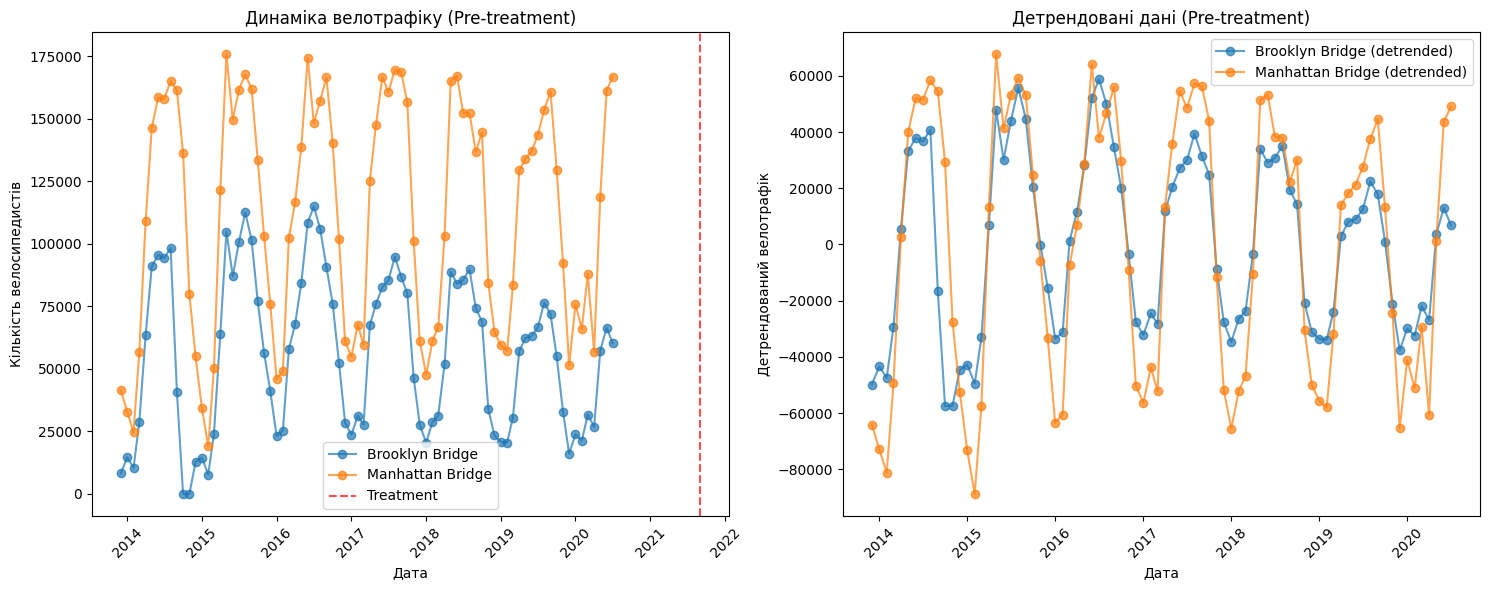


=== ЕТАП 3: БАЗОВА DiD ОЦІНКА ===
Результати базової DiD регресії:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.455e+04   4476.723     14.419      0.000    5.58e+04    7.33e+04
Treatment  -6.127e+04   2907.081    -21.076      0.000    -6.7e+04   -5.56e+04
Post        1.795e+04   2817.845      6.369      0.000    1.24e+04    2.35e+04
DiD         2.671e+04   4515.812      5.916      0.000    1.79e+04    3.56e+04
Month_2     -181.2273   5907.598     -0.031      0.976   -1.18e+04    1.14e+04
Month_3     2.171e+04   5527.246      3.928      0.000    1.09e+04    3.25e+04
Month_4     4.976e+04   5559.067      8.951      0.000    3.89e+04    6.07e+04
Month_5     8.051e+04   5554.227     14.496      0.000    6.96e+04    9.14e+04
Month_6     8.751e+04   5576.129     15.694      0.000    7.66e+04    9.84e+04
Month_7     8.589e+04   5343.482     16.074      0.000    7.54e

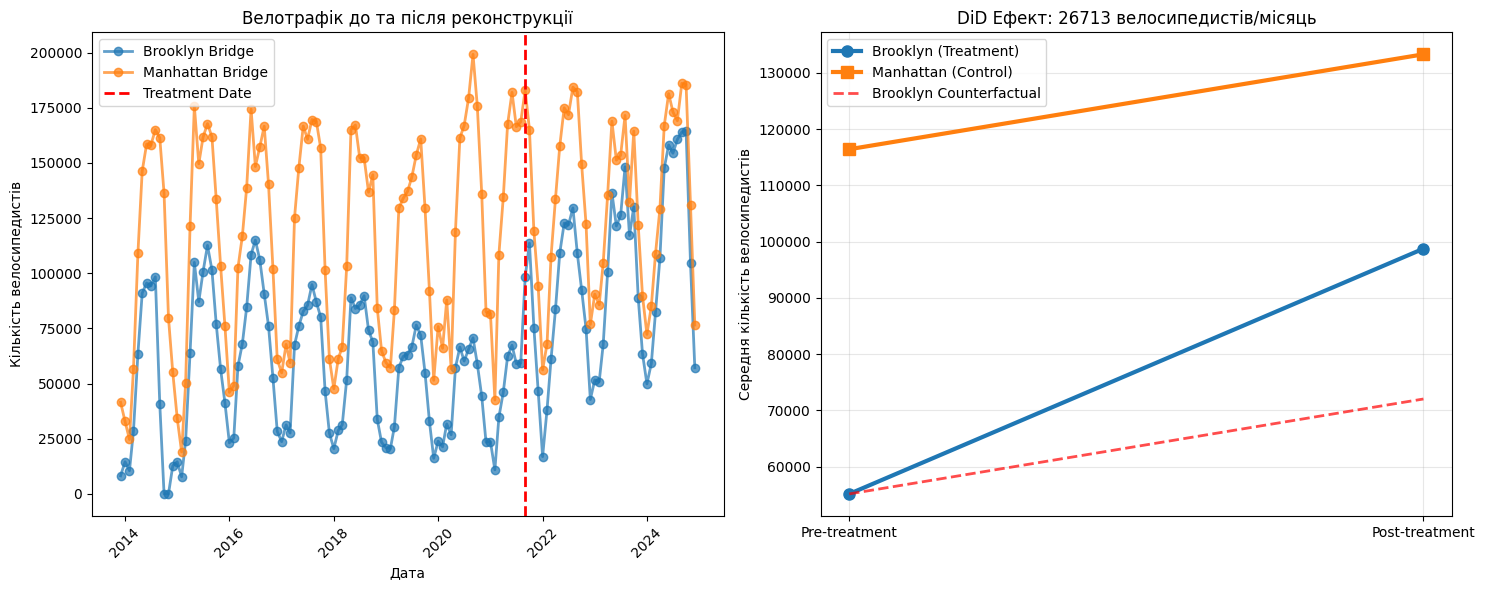


=== ЕТАП 4: ТЕСТИ НА РОБАСТНІСТЬ ===

1. Альтернативні точки розділу:
   2021-08-01: Ефект = 22886.98, p-value = 0.0000
   2021-09-01: Ефект = 25206.34, p-value = 0.0000
   2021-10-01: Ефект = 26713.31, p-value = 0.0000
   2021-11-01: Ефект = 27054.90, p-value = 0.0000

2. Виключення COVID періоду:
   Без COVID: Ефект = 20469.59, p-value = 0.0000

3. Тільки весна-літо (березень-серпень):
   Весна-літо: Ефект = 33276.03, p-value = 0.0000

=== ЕТАП 5: ПІДСУМКОВИЙ ЗВІТ ===
ПІДСУМКОВИЙ ЗВІТ DiD АНАЛІЗУ
Досліджуваний період: 2013-12 - 2024-12
Treatment група: Brooklyn Bridge
Control група: Manhattan Bridge
Дата втручання: Вересень 2021

ОСНОВНІ РЕЗУЛЬТАТИ:
• DiD ефект: 26713 велосипедистів на місяць
• Стандартна помилка: 4516
• 95% довірчий інтервал: [17862, 35564]
• p-value: 0.0000
• Відносний ефект: 48.4%

Статистична значущість: ***

ІНТЕРПРЕТАЦІЯ:
• Реконструкція велодоріжки на Бруклінському мості збільшив
  велосипедний трафік на 26713 поїздок на місяць
• Цей ефект є статистично значу

{'analysis': <__main__.DiDAnalysis at 0x7c1919af3e90>,
 'parallel_trends': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7c1919c4e240>,
 'basic_model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7c191997c4a0>,
 'robustness': {'Cutoff_2021-08-01': {'effect': np.float64(22886.982237539753),
   'pvalue': np.float64(3.3899471631238405e-06)},
  'Cutoff_2021-09-01': {'effect': np.float64(25206.338978494594),
   'pvalue': np.float64(3.2648071506838974e-08)},
  'Cutoff_2021-10-01': {'effect': np.float64(26713.312875068113),
   'pvalue': np.float64(3.308566655963403e-09)},
  'Cutoff_2021-11-01': {'effect': np.float64(27054.899999999907),
   'pvalue': np.float64(3.004793295205836e-09)},
  'No_COVID': {'effect': np.float64(20469.5856410255),
   'pvalue': np.float64(5.626484928144793e-06)},
  'Spring_Summer': {'effect': np.float64(33276.027777777694),
   'pvalue': np.float64(1.2759417973957945e-09)}}}

In [36]:
results = run_complete_analysis(df)
results